# Merton Jump-Diffusion Model for Option Pricing & Implied Volatility Surfaces

In the **Merton jump-diffusion model**, the underlying asset \( S_t \) follows a process that combines continuous diffusion with random jumps. Its dynamics are given by:

$$
dS_t = (\mu - \lambda k) S_t \, dt + \sigma S_t \, dW_t + S_t \, \bigl(e^Y - 1\bigr) \, dN_t,
$$

where:
- \( \mu \) is the drift,
- \( \sigma \) is the volatility of the diffusive (Brownian motion) part,
- \( dW_t \) is the increment of a standard Brownian motion,
- \( dN_t \) is the increment of a Poisson process with intensity \( \lambda \) (i.e., the expected number of jumps per unit time),
- \( Y \) is the log-jump size, assumed to be normally distributed as \( Y \sim \mathcal{N}(\mu_J, \sigma_J^2) \); hence, the jump factor is \( e^Y - 1 \).

Here, the parameter

$$
k = E\left[e^Y\right] - 1 = e^{\mu_J + \frac{1}{2}\sigma_J^2} - 1
$$

adjusts the drift to compensate for the average jump impact.

---

## Option Pricing under Merton's Model

The price of a European call option is known analytically and available in the book section 5.2.1. Below is the formula provided by AI.

The price of a European call option under this model can be expressed as an infinite sum of Black-Scholes prices weighted by the probability of \( m \) jumps occurring over the option's lifetime \( T \):

$$
C(S_0, K, T) = \sum_{m=0}^{\infty} \frac{e^{-\lambda T} (\lambda T)^m}{m!} \; BS\Biggl(S_0 \, e^{-m\left(\mu_J + \frac{1}{2}\sigma_J^2\right)},\, K,\, T,\, \sqrt{\sigma^2 + \frac{m\,\sigma_J^2}{T}} \Biggr),
$$

where \( BS(\cdot) \) denotes the standard Black-Scholes call price function:

$$
BS(S, K, T, \tilde{\sigma}) = S\, N(d_1) - K \, e^{-rT}\, N(d_2),
$$

with

$$
d_1 = \frac{\ln \frac{S}{K} + \left(r+\frac{1}{2}\tilde{\sigma}^2\right) T}{\tilde{\sigma}\sqrt{T}}, \quad d_2 = d_1 - \tilde{\sigma}\sqrt{T}.
$$

In the summation above:
- The term \( S_0 \, e^{-m\left(\mu_J + \frac{1}{2}\sigma_J^2\right)} \) adjusts the spot price for the effect of \( m \) jumps.
- The volatility is effectively increased to

  $$
  \tilde{\sigma}_m = \sqrt{\sigma^2 + \frac{m\,\sigma_J^2}{T}},
  $$

  reflecting the additional uncertainty contributed by the jump process.

---

## Implied Volatility Surface

Even though we compute the call price using the Merton model, market practitioners often quote option prices in terms of the Black-Scholes implied volatility. For a given option price \( C \) obtained from the Merton model, we numerically invert the Black-Scholes formula to obtain the implied volatility \( \sigma_{\text{imp}} \).

By varying the jump parameters:
- **Mean Jump Size (\( \mu_J \)):**  
  A higher (or more positive) \( \mu_J \) tends to **steepen the volatility smile** (skew), as upward jumps raise the value at higher strikes.
  
- **Jump Volatility (\( \sigma_J \)):**  
  A larger \( \sigma_J \) **widens the smile** because the uncertainty associated with jump sizes adds extra dispersion to the asset's returns.
  
- **Jump Intensity (\( \lambda \)):**  
  A higher \( \lambda \) (more frequent jumps) generally leads to **higher implied volatilities** across strikes.

We can analyze these effects by plotting the implied volatility curves (implied volatility vs. strike price) under three different scenarios:
1. **Varying \( \mu_J \):** Keeping \( \sigma_J \) and \( \lambda \) constant.
2. **Varying \( \sigma_J \):** Keeping \( \mu_J \) and \( \lambda \) constant.
3. **Varying \( \lambda \):** Keeping \( \mu_J \) and \( \sigma_J \) constant.

This analysis helps us understand how jump risk impacts option prices and the shape of the implied volatility surface.

---

*Feel free to extend this summary to include further discussions or analyses on the impact of jumps on option pricing and risk management.*


/var/folders/n8/19ypk1rs6tdbh7vcb43bfl0c0000gn/T/ipykernel_5241/2460965942.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) * tau) / float(sigma * np.sqrt(tau))


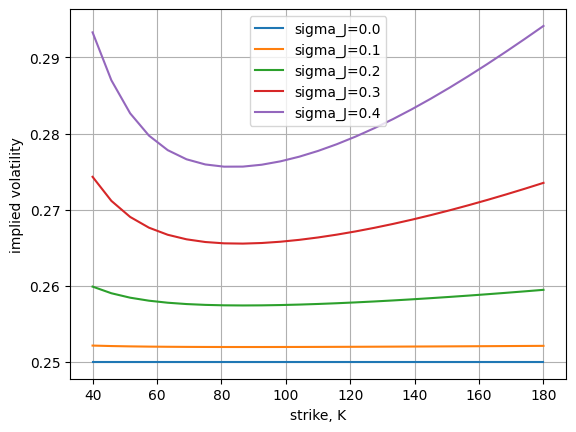

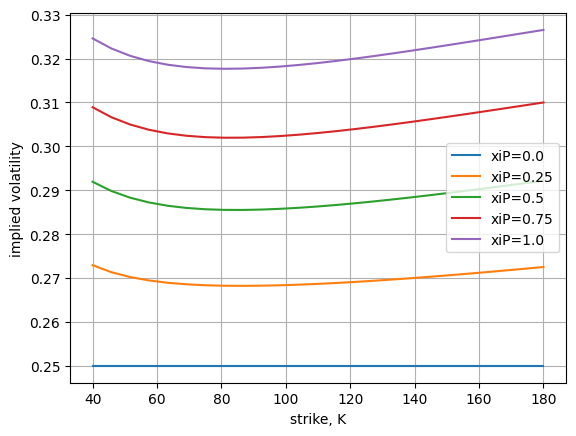

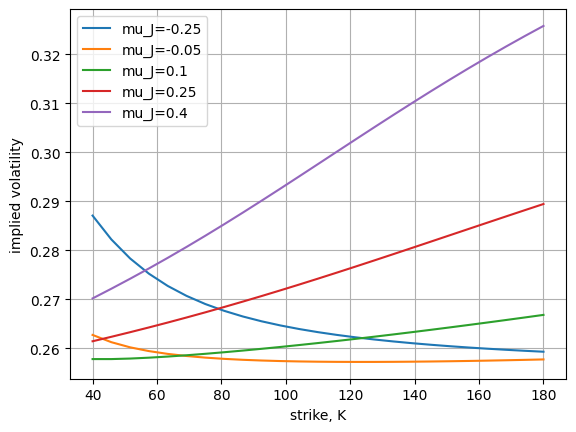

In [17]:
#%%
"""
Created on Thu Nov 30 2018
Merton Model and implied volatilities obtained with the COS method
@author: Lech A. Grzelak
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import enum 
import scipy.optimize as optimize

# Set i= imaginary number

i   = complex(0.0,1.0)

# This class defines puts and calls

class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0
    
# Black-Scholes call option price

def BS_Call_Option_Price(CP,S_0,K,sigma,tau,r):
    
    K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) * tau) / float(sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1)*S_0
    return value

# Implied volatility method

def ImpliedVolatility(CP,marketPrice,K,T,S_0,r,initialVol = 0.4):
    func = lambda sigma: np.power(BS_Call_Option_Price(CP,S_0,K,sigma,T,r) - marketPrice, 1.0)
    impliedVol = optimize.newton(func, initialVol, tol=1e-7)
    
    return impliedVol

def MertonCallPrice(CP,S0,K,r,tau,muJ,sigmaJ,sigma,xiP):
    X0  = np.log(S0)

    # Term for E(exp(J)-1)

    helpExp = np.exp(muJ + 0.5 * sigmaJ * sigmaJ) - 1.0
           
    # Analytic representation for the Merton model option price

    muX     = lambda n: X0 + (r - xiP * helpExp - 0.5 * sigma * sigma) * tau + n * muJ
    sigmaX  = lambda n: np.sqrt(sigma * sigma + n * sigmaJ * sigmaJ / tau) 
    d1      = lambda n: (np.log(S0/K) + (r - xiP * helpExp - 0.5*sigma * sigma \
            + np.power(sigmaX(n),2.0)) * tau + n * muJ) / (sigmaX(n) * np.sqrt(tau))
    d2      = lambda n: d1(n) - sigmaX(n) * np.sqrt(tau)
    value_n = lambda n: np.exp(muX(n) + 0.5*np.power(sigmaX(n),2.0)*tau)\
            * st.norm.cdf(d1(n)) - K *st.norm.cdf(d2(n))
    
    # Option value calculation, it is an infinite sum but we truncate at 20

    valueExact = value_n(0.0)
    kidx = range(1,20)
    for k in kidx:
        valueExact += np.power(xiP * tau, k)*value_n(k) / math.factorial(k)
    valueExact *= np.exp(-r*tau) * np.exp(-xiP * tau)
    return valueExact


def mainCalculation():
    CP  = OptionType.CALL
    S0  = 100
    r   = 0.0
    tau = 2
    
    K = np.linspace(40,180,25)
    K = np.array(K).reshape([len(K),1])

    sigma  = 0.25
    muJ    = 0.0
    sigmaJ = 0.2
    xiP    = 0.1
     
    # Effect of sigmaJ

    plt.figure(1)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    sigmaJV =[0.0, 0.1, 0.2, 0.3, 0.4]
    legend = []
    for sigmaJtemp in sigmaJV:    

        # Evaluate the Merton model

        valueExact = MertonCallPrice(CP,S0,K,r,tau,muJ,sigmaJtemp,sigma,xiP)
        
        # Implied volatilities

        IV =np.zeros([len(K),1])
        for idx in range(0,len(K)):
            IV[idx] = ImpliedVolatility(CP,valueExact[idx],K[idx],tau,S0,r)
        plt.plot(K,IV)
        legend.append('sigma_J={0}'.format(sigmaJtemp))
    plt.legend(legend)
    
      # Effect of xi_P

    plt.figure(2)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    #sigmaJ = 0.25
    #muJ    = 0.0
    xiPV   = [0.0, 0.25, 0.5, 0.75, 1.0]
    legend = []
    for xiPtemp in xiPV:    

        # Evaluate the Merton model

        valueExact = MertonCallPrice(CP,S0,K,r,tau,muJ,sigmaJ,sigma,xiPtemp)
        
        # Implied volatilities

        IV =np.zeros([len(K),1])
        for idx in range(0,len(K)):
            IV[idx] = ImpliedVolatility(CP,valueExact[idx],K[idx],tau,S0,r,0.3)
        
        #plt.figure()
        plt.plot(K,IV)
        legend.append('xiP={0}'.format(xiPtemp))
    plt.legend(legend)
    
     # Effect of mu_J

    plt.figure(3)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    #sigmaJ = 0.25
    #xiP    = 0.5
    muJV = [-0.25, -0.05, 0.1, 0.25, 0.4]
    legend = []
    for muJtemp in muJV:    

        # Evaluate the Merton model

        valueExact = MertonCallPrice(CP,S0,K,r,tau,muJtemp,sigmaJ,sigma,xiP)
        
        # Implied volatilities

        IV =np.zeros([len(K),1])
        for idx in range(0,len(K)):
            IV[idx] = ImpliedVolatility(CP,valueExact[idx],K[idx],tau,S0,r)
        plt.plot(K,IV)
        legend.append('mu_J={0}'.format(muJtemp))
    plt.legend(legend)
    
      
mainCalculation()

<>:86: SyntaxWarning: invalid escape sequence '\m'
<>:89: SyntaxWarning: invalid escape sequence '\m'
<>:108: SyntaxWarning: invalid escape sequence '\s'
<>:111: SyntaxWarning: invalid escape sequence '\s'
<>:130: SyntaxWarning: invalid escape sequence '\l'
<>:133: SyntaxWarning: invalid escape sequence '\l'
<>:86: SyntaxWarning: invalid escape sequence '\m'
<>:89: SyntaxWarning: invalid escape sequence '\m'
<>:108: SyntaxWarning: invalid escape sequence '\s'
<>:111: SyntaxWarning: invalid escape sequence '\s'
<>:130: SyntaxWarning: invalid escape sequence '\l'
<>:133: SyntaxWarning: invalid escape sequence '\l'
/var/folders/n8/19ypk1rs6tdbh7vcb43bfl0c0000gn/T/ipykernel_5241/1892165184.py:86: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(strikes, iv_curve, marker='o', label=f'$\mu_J$ = {mu_J}')
/var/folders/n8/19ypk1rs6tdbh7vcb43bfl0c0000gn/T/ipykernel_5241/1892165184.py:89: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Implied Vol Surface: Varying $\mu_J$ (fixed $\

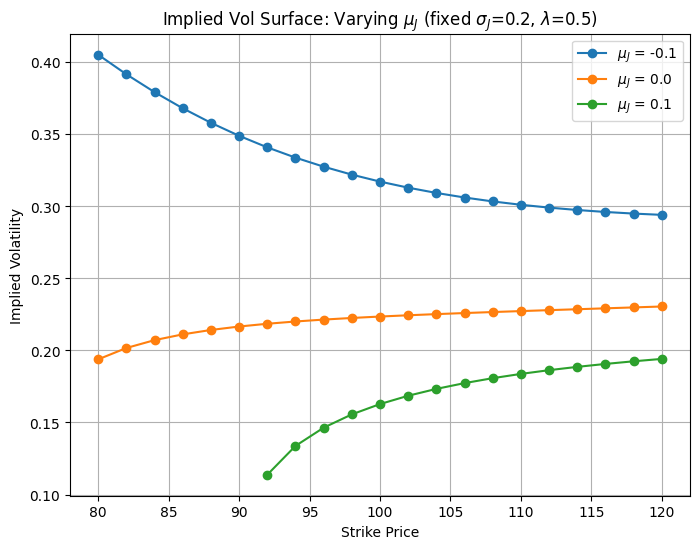

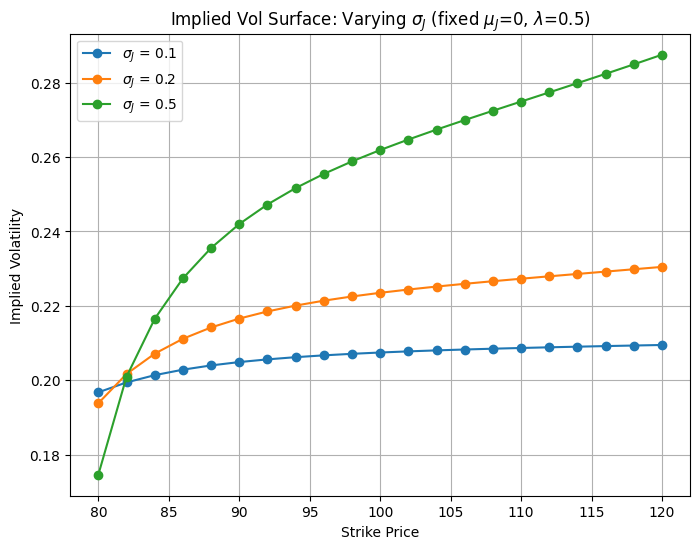

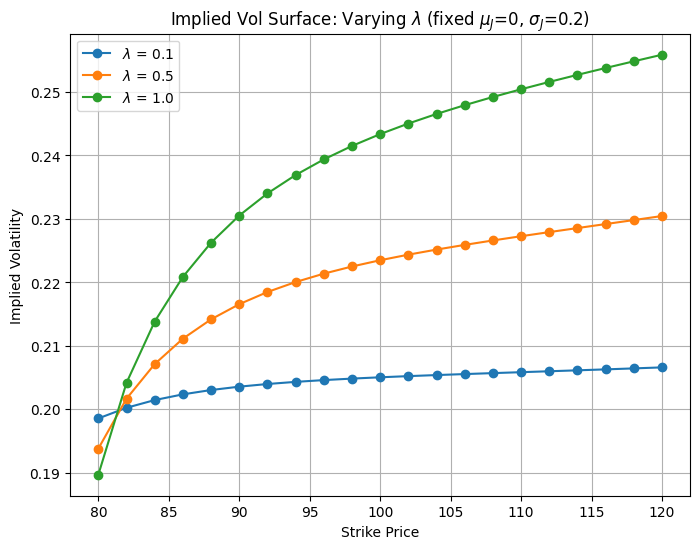

In [18]:
import numpy as np
import math
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# ------------------------------
# Black-Scholes Call Price Function
# ------------------------------
def black_scholes_call(S, K, T, r, sigma):
    # Avoid division by zero for very small sigma*T^(1/2)
    if sigma * np.sqrt(T) < 1e-12:
        return max(S - K, 0)
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * st.norm.cdf(d1) - K * np.exp(-r*T) * st.norm.cdf(d2)

# ------------------------------
# Merton Jump-Diffusion Call Price Function
# ------------------------------
def merton_jump_call(S, K, T, r, sigma, mu_J, sigma_J, lambda_):
    """
    Prices a European call option under Merton's jump-diffusion model.
    The asset dynamics are:
      dS_t = (μ - λk)S_t dt + σ S_t dW_t + S_t (e^Y - 1) dN_t,
    with Y ~ N(mu_J, sigma_J^2) and k = E[e^Y] - 1.
    
    The option price is computed as an infinite sum (truncated to N_max terms)
    of Black-Scholes prices weighted by the Poisson probability of m jumps.
    """
    N_max = 50  # upper limit of summation
    call_price = 0.0
    # k = E[e^Y] - 1 = exp(mu_J + 0.5*sigma_J^2) - 1.
    k = np.exp(mu_J + 0.5 * sigma_J**2) - 1
    for m in range(N_max):
        poisson_prob = np.exp(-lambda_ * T) * (lambda_ * T)**m / math.factorial(m)
        # Adjust spot price: each jump on average multiplies S by exp(Y), so adjusting by
        # the compensation factor log(1+k). (This is one way to incorporate the drift adjustment.)
        S_adj = S * np.exp(-m * np.log(1 + k))
        # Adjust volatility: additional variance comes from jump uncertainty.
        sigma_m = np.sqrt(sigma**2 + (m * sigma_J**2) / T)
        call_price += poisson_prob * black_scholes_call(S_adj, K, T, r, sigma_m)
    return call_price

# ------------------------------
# Implied Volatility via Brentq
# ------------------------------
def implied_vol_call(S, K, T, r, market_price):
    """
    Given a market price, numerically solve for the implied volatility using
    the Black-Scholes formula. Uses the Brent-Q method for robust root-finding.
    """
    def objective(sigma):
        return black_scholes_call(S, K, T, r, sigma) - market_price
    try:
        iv = brentq(objective, 1e-6, 5.0)
    except Exception:
        iv = np.nan
    return iv

# ------------------------------
# Common Market Parameters
# ------------------------------
S0 = 100     # Underlying asset price
T  = 1.0     # Maturity (1 year)
r  = 0.05    # Risk-free interest rate
sigma = 0.2 # Diffusive volatility

# Range of strike prices for analysis
strikes = np.arange(80, 121, 2)

# ------------------------------
# Graph 1: Varying mu_J (Mean of jump sizes)
# ------------------------------
mu_J_vals = [-0.1, 0.0, 0.1]  # Different mean levels
fixed_sigma_J = 0.2           # fixed jump vol
fixed_lambda  = 0.5           # fixed jump intensity

plt.figure(figsize=(8,6))
for mu_J in mu_J_vals:
    iv_curve = []
    for K in strikes:
        price = merton_jump_call(S0, K, T, r, sigma, mu_J, fixed_sigma_J, fixed_lambda)
        iv = implied_vol_call(S0, K, T, r, price)
        iv_curve.append(iv)
    plt.plot(strikes, iv_curve, marker='o', label=f'$\mu_J$ = {mu_J}')
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title("Implied Vol Surface: Varying $\mu_J$ (fixed $\sigma_J$=0.2, $\lambda$=0.5)")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# Graph 2: Varying sigma_J (Jump Volatility)
# ------------------------------
sigma_J_vals = [0.1, 0.2, 0.5]  # Different jump volatilities
fixed_mu_J = 0.0                # fixed mean of jump sizes
fixed_lambda  = 0.5             # fixed jump intensity

plt.figure(figsize=(8,6))
for sigma_J in sigma_J_vals:
    iv_curve = []
    for K in strikes:
        price = merton_jump_call(S0, K, T, r, sigma, fixed_mu_J, sigma_J, fixed_lambda)
        iv = implied_vol_call(S0, K, T, r, price)
        iv_curve.append(iv)
    plt.plot(strikes, iv_curve, marker='o', label=f'$\sigma_J$ = {sigma_J}')
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title("Implied Vol Surface: Varying $\sigma_J$ (fixed $\mu_J$=0, $\lambda$=0.5)")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# Graph 3: Varying lambda (Jump Intensity)
# ------------------------------
lambda_vals = [0.1, 0.5, 1.0]  # Different jump intensities
fixed_mu_J    = 0.0           # fixed mean of jump sizes
fixed_sigma_J = 0.2           # fixed jump volatility

plt.figure(figsize=(8,6))
for lambda_ in lambda_vals:
    iv_curve = []
    for K in strikes:
        price = merton_jump_call(S0, K, T, r, sigma, fixed_mu_J, fixed_sigma_J, lambda_)
        iv = implied_vol_call(S0, K, T, r, price)
        iv_curve.append(iv)
    plt.plot(strikes, iv_curve, marker='o', label=f'$\lambda$ = {lambda_}')
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title("Implied Vol Surface: Varying $\lambda$ (fixed $\mu_J$=0, $\sigma_J$=0.2)")
plt.legend()
plt.grid(True)
plt.show()
